In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature
import pandas as pd

from scipy import stats
import matplotlib.cm as cm
import matplotlib

# Parent particle

plot the trajectorie(s) of particles that don't fragment. 

count the number of fragmentation events

In [2]:
sim = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/set_16/set16_500.zarr/')
sim = sim.compute()

In [3]:
def filter_trajectories_depth(data, depthlim):
    
    k, _ = np.where(data['seafloor'] < depthlim)
    index = np.unique(k)
    
    data_relevant = data.where(data['trajectory'].isin(index), drop=True)
    data_relevant = data_relevant.where(data_relevant['seafloor'] > depthlim, drop=True)

    return data_relevant

In [4]:
def find_parent(data, diameter_cond, end_dt):
    indexes = np.where(data['diameter'][:, end_dt] < diameter_cond)
    data_relevant = data.where(data['trajectory'].isin(indexes), drop=True)

    return data_relevant

In [5]:
parent = find_parent(sim, 6e-8, 4855)
shelf_sims = {}

# time_dim = 4856


for ft in [500, 2500, 5000, 50000]:
    print(ft)
    sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_16/set16_{ft}.zarr')
    sim = filter_trajectories_depth(sim, 200)
    
    shelf_sims[ft] = sim


500
2500
5000
50000


In [6]:
shp_dict = {}
files = glob('../data/ne_10m_bathymetry_all/*.shp')
assert len(files) > 0
files.sort()
for f in files:
    depth = f.split('_')[-1].split('.')[0]
    # depth = '-' + f.split('_')[-1].split('.')[0]
    # depths.append(depth)
    nei = cart.io.shapereader.Reader(f)
    shp_dict[depth] = nei

depths = [d for d in shp_dict.keys()][::-1]
colors = sns.mpl_palette('cmo.ice_r',n_colors=8)
cmap   = sns.mpl_palette('cmo.ice',n_colors=8,as_cmap=True)

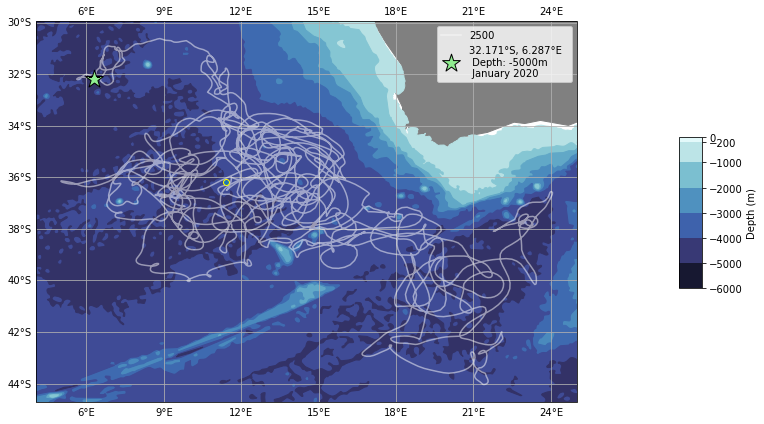

In [7]:
max_depth = -5500
min_depth = 0 

fig = plt.figure(figsize=(13,7))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent((-5, 20, -40, -25), crs=ccrs.PlateCarree())

i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1

ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
              zorder=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.910,0.35,0.025,0.3])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

ax.scatter(6.287, -32.171, marker='*',
           zorder=5, color='lightgreen', 
           label='32.171°S, 6.287°E  \n Depth: -5000m \n January 2020', 
           s=350,
          edgecolors='black')

# frame = -1
# ax.plot(sim['lon'][8372,:], sim['lat'][8372,:], zorder=4, c='yellow')
# ax.scatter(shelf['lon'][:,:], shelf['lat'][:,:], zorder=5, c='red')
# ax.scatter(sim['lon'][8372,-10], sim['lat'][8372,-10], zorder=5, c='red')

ft = 2500

colorz = plt.rcParams["axes.prop_cycle"]()

c = next(colorz)['color']
t=0

# for ft in [500, 2500, 5000, 50000]:
#     print(ft)
ax.plot(parent['lon'][t,:], parent['lat'][t,:], alpha=0.5, label=ft, color='w')
ax.scatter(parent['lon'][t,-1], parent['lat'][t,-1], zorder=5, edgecolors='yellow')

    
ax.legend(fontsize=10)
# bar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.03])
# fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle diameter (m)')
# ax.set_title('10 years before sampling', fontsize=15, weight='bold')
plt.savefig('../figs/conti_shelf_multift.png')

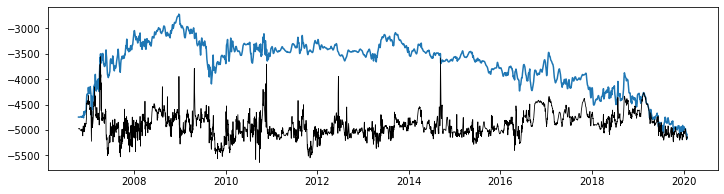

In [8]:
plt.figure(figsize=(12,3))
ft = 500
# for ft in [500, 2500, 5000, 50000]:
plt.plot(parent['time'][0], -parent['z'][0])


plt.plot(parent['time'][0], -parent['seafloor'][0], color='k', lw=0.8)

In [9]:
shelf_sims[500].dims['traj']

25

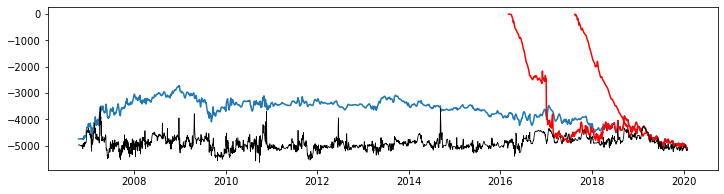

In [10]:
plt.figure(figsize=(12,3))
ft = 500
# for ft in [500, 2500, 5000, 50000]:
plt.plot(parent['time'][0], -parent['z'][0])

plt.plot(shelf_sims[500]['time'][1], -shelf_sims[500]['z'][1], c='r')
plt.plot(shelf_sims[500]['time'][0], -shelf_sims[500]['z'][0], c='r')


plt.plot(parent['time'][0], -parent['seafloor'][0], color='k', lw=0.8)

In [11]:
w = xr.load_dataset('/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_W_2021-11-27.nc')

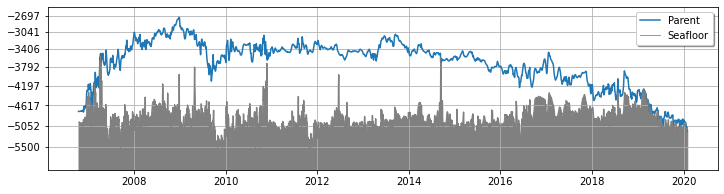

In [12]:
fig, ax = plt.subplots(figsize=(12,3))
ft = 500
# for ft in [500, 2500, 5000, 50000]:


# for idx in index:
#     ax.scatter(parent[ft]['time'][0, idx], -parent[ft]['z'][0, idx], color='r')

# colorz = plt.rcParams["axes.prop_cycle"]()
# for ft in [500, 2500, 5000, 50000]:
#     c = next(colorz)['color']
#     n_trj = shelf_sims[ft].dims['traj']
    
#     for k in range(n_trj):
#         ax.plot(shelf_sims[ft]['time'][k], -shelf_sims[ft]['z'][k], color=c)
        
        
ax.plot(parent['time'][0], -parent['z'][0], label='Parent')
ax.plot(parent['time'][0], -parent['seafloor'][0], color='gray', lw=0.8, label='Seafloor')
ax.fill_between(parent['time'][0], -parent['seafloor'][0], -6000, color='gray')

ax.set_yticks(-w['depthw'], minor=False);
ax.grid()
ax.set_ylim(-6000, -2500)
ax.legend(shadow=True)

No handles with labels found to put in legend.


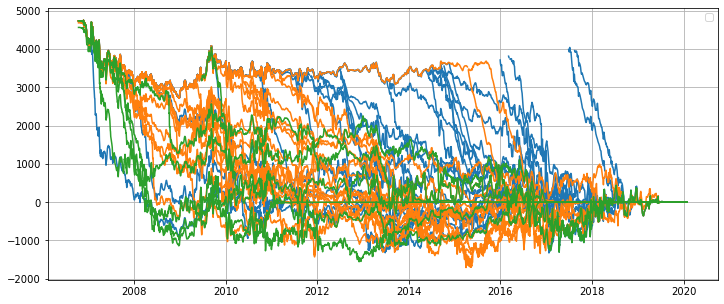

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
ft = 500
# for ft in [500, 2500, 5000, 50000]:


# for idx in index:
#     ax.scatter(parent[ft]['time'][0, idx], -parent[ft]['z'][0, idx], color='r')

colorz = plt.rcParams["axes.prop_cycle"]()
for ft in [500, 2500, 5000, 50000]:
    c = next(colorz)['color']
    n_trj = shelf_sims[ft].dims['traj']
    
    for k in range(n_trj):
        ax.plot(shelf_sims[ft]['time'][k], parent['z'][0] - shelf_sims[ft]['z'][k], color=c)
        
        
# ax.plot(parent['time'][0], -parent['z'][0], label='Parent')
# ax.plot(parent['time'][0], -parent['seafloor'][0], color='k', lw=0.8, label='Seafloor')

# ax.set_yticks(-w['depthw'], minor=False);
ax.grid()
# ax.set_ylim(-6000, -2500)
ax.legend()

In [14]:
colorz = plt.rcParams["axes.prop_cycle"]()
for ft in [500, 2500, 5000, 50000]:
    c = next(colorz)['color']
    n_trj = shelf_sims[ft].dims['traj']
    
    for k in range(n_trj):
        ax.plot(shelf_sims[ft]['time'][k], -shelf_sims[ft]['z'][k], color=c)

In [15]:
plt.figure(figsize=(12,3))
ft =500
# for ft in [500, 2500, 5000, 50000]:
plt.plot(parent[ft]['time'][0], -parent[ft]['z'][0])
plt.plot(parent[ft]['time'][0], -parent[ft]['seafloor'][0], color='k', lw=0.8)

for idx in index:
    plt.scatter(parent[ft]['time'][0, idx], -parent[ft]['z'][0, idx], color='r')

plt.grid()

KeyError: 500

<Figure size 864x216 with 0 Axes>

In [ ]:
max_depth = -5500
min_depth = 0 

fig = plt.figure(figsize=(13,7))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent((-5, 20, -40, -25), crs=ccrs.PlateCarree())

i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1

ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
              zorder=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.910,0.35,0.025,0.3])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

ax.scatter(6.287, -32.171, marker='*',
           zorder=5, color='lightgreen', 
           label='End', 
           s=350,
          edgecolors='black')

# frame = -1
# ax.plot(sim['lon'][8372,:], sim['lat'][8372,:], zorder=4, c='yellow')
# ax.scatter(shelf['lon'][:,:], shelf['lat'][:,:], zorder=5, c='red')
# ax.scatter(sim['lon'][8372,-10], sim['lat'][8372,-10], zorder=5, c='red')

ft = 500

colorz = plt.rcParams["axes.prop_cycle"]()

c = next(colorz)['color']
t=0


   
ax.plot(parent[ft]['lon'][t,:], parent[ft]['lat'][t,:], alpha=0.5, color='w', lw=2)
ax.scatter(parent[ft]['lon'][t,-1], parent[ft]['lat'][t,-1], zorder=5, edgecolors='yellow', label='start')


ax.scatter(parent[ft]['lon'][t, index[-1]], parent[ft]['lat'][t, index[-1]], color='gold', s=50, zorder=6, alpha=0.9, marker='*', label=parent[ft]['time'][0, index[-1]].values)
ax.scatter(parent[ft]['lon'][t, index[-3]], parent[ft]['lat'][t, index[-3]], color='gold', s=50, zorder=6, alpha=0.9, marker='o', label=parent[ft]['time'][0, index[-3]].values)

for idx in index[:-3]:
    ax.scatter(parent[ft]['lon'][t, idx], parent[ft]['lat'][t, idx], color='r', zorder=5, alpha=0.5, marker='+')
    
ax.legend(fontsize=10)
# bar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.03])
# fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle diameter (m)')
# ax.set_title('10 years before sampling', fontsize=15, weight='bold')
plt.savefig('../figs/conti_shelf_multift.png')

# Regimes

Advenction + diffusion  vs. settleng velocity 

In [18]:
parent

<xarray.Dataset>
Dimensions:           (traj: 3, obs: 4856)
Dimensions without coordinates: traj, obs
Data variables: (12/19)
    Kz                (traj, obs) float32 9.771e-05 6.009e-05 ... 1.809e-05
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... 34.72 34.72
    cons_temperature  (traj, obs) float32 0.725 0.7254 0.7212 ... 0.6039 0.6038
    density           (traj, obs) float32 1.028e+03 1.028e+03 ... 1.028e+03
    diameter          (traj, obs) float64 5.023e-08 5.023e-08 ... 5.061e-08
    lat               (traj, obs) float64 -32.17 -32.15 -32.11 ... -36.18 -36.18
    ...                ...
    u                 (traj, obs) float32 4.897e-07 4.266e-07 ... 4.519e-09
    v                 (traj, obs) float32 -2.033e-07 -3.349e-07 ... 3.077e-09
    v_s               (traj, obs) float32 0.0 4.706e-10 ... 4.778e-10 4.778e-10
    w                 (traj, obs) float32 -0.0002963 -0.0003353 ... 7.932e-06
    w_k               (traj, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    z                 (traj, obs) float64 5.17e+03 5.124e+03 ... 4.747e+03
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-303-gd31c5f32

In [19]:
coeff_parent = abs(parent['w'][0].values + parent['w_k'][0].values)/abs(parent['v_s'][0].values) 

/tmp/ipykernel_2973444/883389103.py:1: RuntimeWarning: divide by zero encountered in true_divide
  coeff_parent = abs(parent['w'][0].values + parent['w_k'][0].values)/abs(parent['v_s'][0].values)


In [20]:
coeff = abs(shelf_sims[2500]['w'].values + shelf_sims[2500]['w_k'].values)/abs(shelf_sims[2500]['v_s'].values)

/tmp/ipykernel_2973444/2188930035.py:1: RuntimeWarning: divide by zero encountered in true_divide
  coeff = abs(shelf_sims[2500]['w'].values + shelf_sims[2500]['w_k'].values)/abs(shelf_sims[2500]['v_s'].values)


In [21]:
coeff_parent.shape

(4856,)

[]

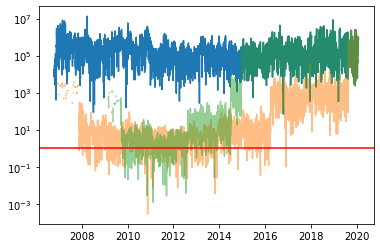

In [22]:
plt.plot(parent['time'][0], coeff_parent)

n=10
plt.plot(shelf_sims[2500]['time'][n], coeff[n], alpha=0.5)
plt.plot(shelf_sims[2500]['time'][1], coeff[1], alpha=0.5)


plt.axhline(1, color='r')
plt.semilogy()

[]

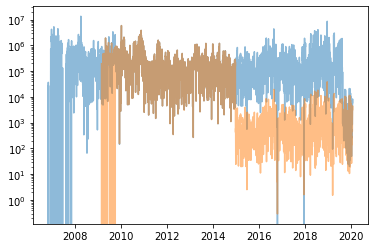

In [23]:
# plt.plot(parent['time'][0], coeff_parent)

n=10
plt.plot(shelf_sims[2500]['time'][n], coeff_parent - coeff[n], alpha=0.5)
plt.plot(shelf_sims[2500]['time'][1], coeff_parent - coeff[1], alpha=0.5)


# plt.axhline(1, color='r')
plt.semilogy()

ValueError: x and y must have same first dimension, but have shapes (4856,) and (19, 4856)

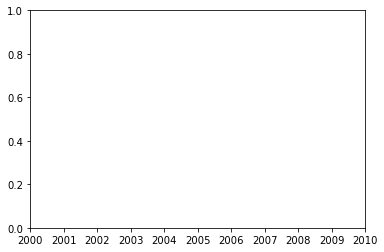

In [24]:
# plt.plot(shelf_sims[2500]['time'][0], sinkin/adv_diff)
# plt.plot(shelf_sims[2500]['time'][1], adv_diff/sinkin)
plt.plot(parent['time'][0], coeff_parent - coeff)
# plt.plot(shelf_sims[2500]['time'][1], )

# plt.axhline(1, color='r')
plt.semilogy()

In [ ]:
plt.plot(shelf_sims[2500]['time'][1], -shelf_sims[2500]['z'][1])
plt.plot()

In [ ]:
plt.plot(shelf_sims[2500]['time'][0], shelf_sims[2500]['diameter'][0])
plt.semilogy()

# Temperature

In [29]:
parent['cons_temperature'][0]

<xarray.DataArray 'cons_temperature' (obs: 4856)>
array([0.7250187 , 0.72544914, 0.72124165, ..., 0.6040078 , 0.603944  ,
       0.60382205], dtype=float32)
Dimensions without coordinates: obs
Attributes:
    long_name:      
    standard_name:  cons_temperature
    units:          unknown

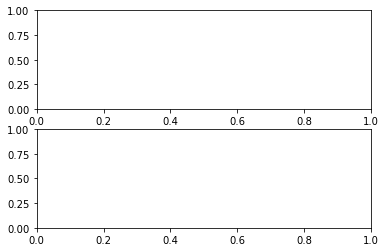

In [33]:
fig, ax= plt.subplots(2)

In [35]:
ax[1]

<AxesSubplot:>

(34.5, 35.0)

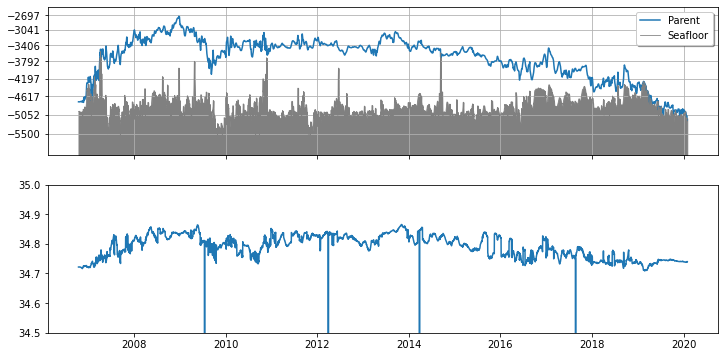

In [47]:
fig, ax = plt.subplots(2, figsize=(12,6), sharex=True)
ft = 500
# for ft in [500, 2500, 5000, 50000]:


# for idx in index:
#     ax.scatter(parent[ft]['time'][0, idx], -parent[ft]['z'][0, idx], color='r')

# colorz = plt.rcParams["axes.prop_cycle"]()
# for ft in [500, 2500, 5000, 50000]:
#     c = next(colorz)['color']
#     n_trj = shelf_sims[ft].dims['traj']
    
#     for k in range(n_trj):
#         ax.plot(shelf_sims[ft]['time'][k], -shelf_sims[ft]['z'][k], color=c)
        
        
ax[0].plot(parent['time'][0], -parent['z'][0], label='Parent')
ax[0].plot(parent['time'][0], -parent['seafloor'][0], color='gray', lw=0.8, label='Seafloor')
ax[0].fill_between(parent['time'][0], -parent['seafloor'][0], -6000, color='gray')

ax[0].set_yticks(-w['depthw'], minor=False);
ax[0].grid()
ax[0].set_ylim(-6000, -2500)
ax[0].legend(shadow=True)

# ax[1].plot(parent['time'][0], parent['cons_temperature'][0], label='Parent')
ax[1].plot(parent['time'][0], parent['abs_salinity'][0], label='Parent')
ax[1].set_ylim(34.5,35)
# ax[1].plot(parent['time'][0], parent['seafloor'][0], color='gray', lw=0.8, label='Seafloor')
# ax[1].fill_between(parent['time'][0], -parent['seafloor'][0], -6000, color='gray')

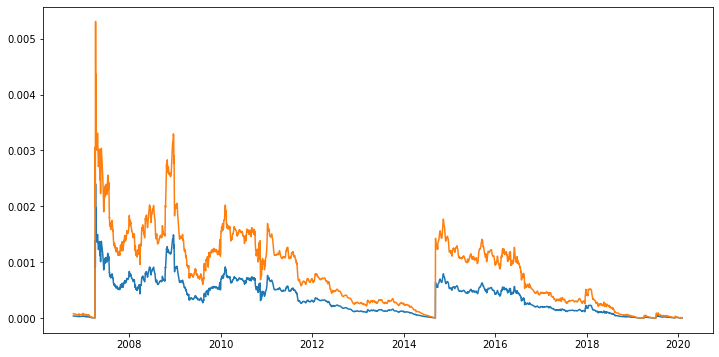

In [52]:
fig, ax = plt.subplots(figsize=(12,6), sharex=True)
ft = 500
# for ft in [500, 2500, 5000, 50000]:


# for idx in index:
#     ax.scatter(parent[ft]['time'][0, idx], -parent[ft]['z'][0, idx], color='r')

# colorz = plt.rcParams["axes.prop_cycle"]()
# for ft in [500, 2500, 5000, 50000]:
#     c = next(colorz)['color']
#     n_trj = shelf_sims[ft].dims['traj']
    
#     for k in range(n_trj):
#         ax.plot(shelf_sims[ft]['time'][k], -shelf_sims[ft]['z'][k], color=c)
        
        
ax.plot(parent['time'][0], parent['z'][0] - parent['z'][1], label='Parent')
ax.plot(parent['time'][0], parent['z'][0] - parent['z'][2], label='Parent')

In [50]:
parent['z'][0] - parent['z'][1]

<xarray.DataArray 'z' (obs: 4856)>
array([0.00000000e+00, 2.29356374e-08, 6.88069122e-08, ...,
       3.60089307e-05, 3.62858391e-05, 3.66211370e-05])
Dimensions without coordinates: obs